In [1]:
print("Kernal Started")

Kernal Started


In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
!pip install Pillow==9.3.0

In [ ]:
!pip install numpy==1.24.1

In [3]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

import google.protobuf

print("Protocol Buffers version:", google.protobuf.__version__)


TensorFlow version: 2.10.0
Keras version: 2.10.0
Protocol Buffers version: 3.19.6


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [5]:
print("Done setup")

Done setup


# Dense121

In [6]:
from keras.applications import DenseNet121
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


train_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/train'
test_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/test'
valid_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/valid'

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=True)

valid_set = valid_datagen.flow_from_directory(valid_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical')


# Set up data
batch_size = 32
img_height = 224
img_width = 224

# Define early stopping and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Dense121_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

Found 1480 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


In [7]:
# Define the number of classes for your classification task
num_classes = 3

# Define the input size for the Dense model
input_shape = (224, 224, 3)

# Load the pre-trained Dense model and exclude the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer and a dense output layer with softmax activation
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model with the Dense base and custom output layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function, optimizer, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# model.summary()



29084464/29084464 [==============================] - 1s 0us/step


In [8]:
# Train the model
history = model.fit(training_set, 
                              validation_data=valid_set,
                              epochs=10,
                              callbacks=[early_stop, model_checkpoint])

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.9196
Epoch 1: val_loss improved from inf to 0.07919, saving model to Dense121_1.h5
47/47 [==============================] - 286s 6s/step - loss: 0.3127 - accuracy: 0.9196 - val_loss: 0.0792 - val_accuracy: 1.0000
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9993
Epoch 2: val_loss improved from 0.07919 to 0.03929, saving model to Dense121_1.h5
47/47 [==============================] - 225s 5s/step - loss: 0.0514 - accuracy: 0.9993 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.03929 to 0.02519, saving model to Dense121_1.h5
47/47 [==============================] - 226s 5s/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 4/10
47/47 [==============================] - ETA: 0s - loss: 0.0196 - accuracy:

In [13]:
model.save('dense121f_1.h5')

import pickle
with open('history_dense121_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Evaluating the Model

In [14]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
test_batches = test_datagen.flow_from_directory(test_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

Found 205 images belonging to 3 classes.


In [17]:
score = model.evaluate(test_batches)
print(score)

7/7 [==============================] - 28s 4s/step - loss: 0.0073 - accuracy: 1.0000
[0.0072889868170022964, 1.0]


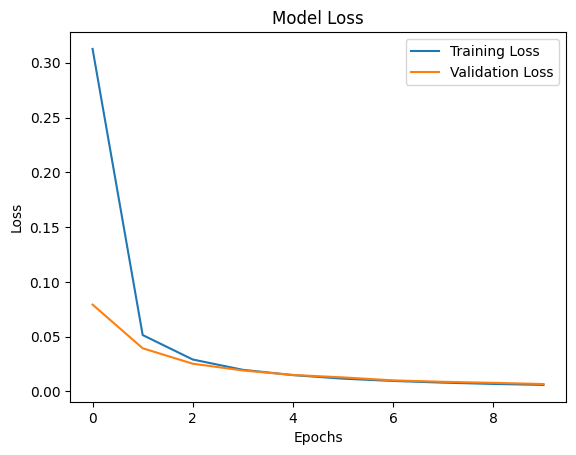

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


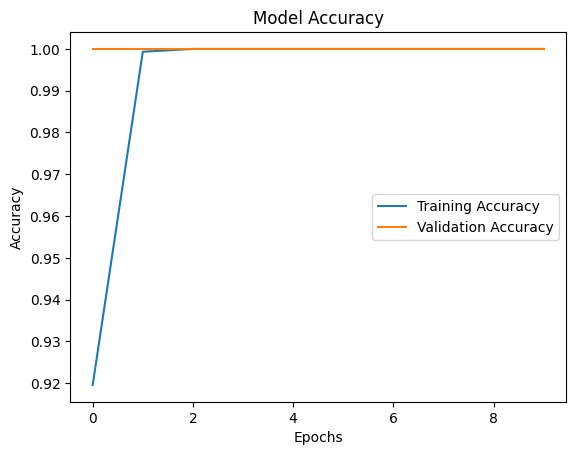

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
plt.show()


In [20]:
predictions= model.predict(test_batches)

7/7 [==============================] - 26s 3s/step


In [22]:
import numpy as np
rounded_prediction = np.argmax(predictions,axis=-1)

In [26]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max()/2.

    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [30]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_true=test_batches.classes,y_pred=rounded_prediction)

In [31]:
cm_plot_labels=["mite","normal","yellow"]

Confusion matrix, without normalization
[[70  0  0]
 [ 0 70  0]
 [ 0  0 65]]


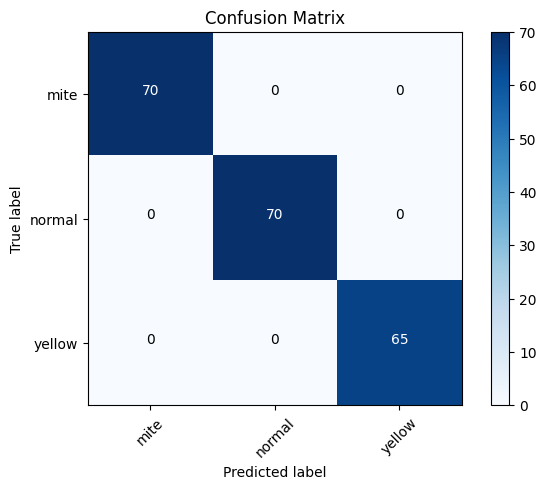

In [32]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [33]:
from sklearn.metrics import classification_report

print(classification_report(test_batches.classes,rounded_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        70
           2       1.00      1.00      1.00        65

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

